In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import multiprocessing as mp
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import curve_fit
import astropy.io.fits as fits

 ### Trabalho 2 
    - Fotometria de abertura em 8 frames de uma ocultação estelar.
    - Intuito de comparar curvas de luz -> faz-se necessário adquirir a medida do fluxo de cada frame
    

 ##### Perguntas a serem respondidas durante a análise:
    
    1. Qual o centróide (x,y) da estrela alvo?
    2. Qual a melhor abertura para fazermos a fotometria do nosso alvo?

In [2]:
im_data = fits.getdata('1262.fits') #Durante o evento

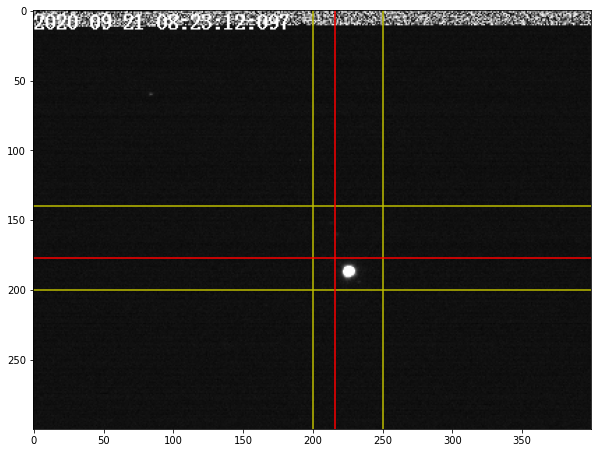

In [3]:
plt.figure(figsize=[10, 10])
plt.axvline(200, color='y')
plt.axvline(250, color='y')
plt.axhline(140, color='y')
plt.axhline(200, color='y')
plt.axvline(216, color='r') #Estrela alvo
plt.axhline(177, color='r') #Estrela alvo
plt.imshow(im_data, cmap='gray')
plt.show()

In [4]:
im_hd = fits.getheader('1262.fits')
im_hd

SIMPLE  =                    T / C# FITS: 9/21/2020 4:23:12 AM                  
BITPIX  =                   16                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                  400                                                  
NAXIS2  =                  300                                                  
OBSLAT  =     44.2613016666667 /                                                
GPSSTAT = 'Locked  '           /                                                
DATE-END= '2020-09-21T08:23:12.1700000' / System Clock-Frame Grabbed            
DATE-OBS= '2020-09-21T08:23:12.0970884' / GPS-Start Exp                         
SWCREATE= 'SharpCap'           /                                                
CCD-TEMP=                 -7.1 /                                                
YBINNING=                    2 /                                                
YPIXSZ  =      5.86000013351

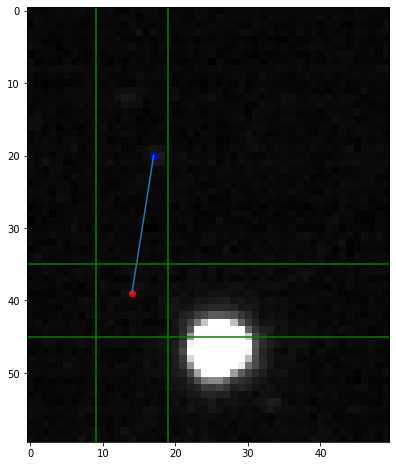

In [5]:
new_data = im_data[140:200,200:250]
plt.figure(figsize=[8, 8])
plt.imshow(new_data, cmap='gray')

## Alvo (inferindo esta posição graças ao calibrador titania.)
plt.plot(14, 39, 'ro') 

##Calibrador
plt.plot(17, 20, 'bo') #Antes estava (18,18) -> dx=-1 dy=-+2


## Distancia entre eles
#plt.plot([1, 10], [1, 10]) irá traçar uma reta ligando os pontos (1,1) e (10,10)
plt.plot([17,14],[20,39])


plt.axvline(9, color='g') 
plt.axvline(19, color='g')
plt.axhline(45, color='g')
plt.axhline(35, color='g')
plt.show()

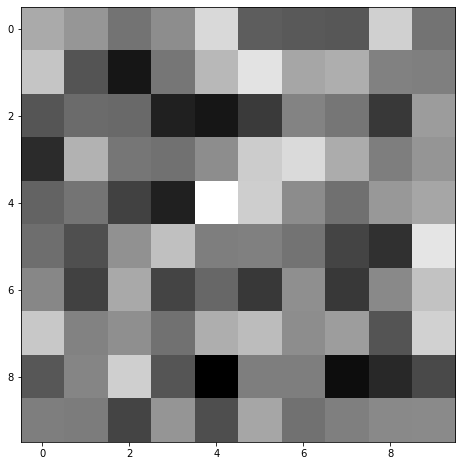

In [6]:
#alvo = new_data[30:44,10:20] # Imagem da estrela alvo mais isolada possivel de Urano. Descartado temporariamente pois ainda é muito afetada por Urano o que afeta o calculo do centro.
alvo = new_data[35:45,9:19] # Imagem da estrela alvo mais isolada possível de Urano. Este recorte limita muito o anel do fundo de ceu.
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray')
#plt.axvline(15, color='r')
#plt.axhline(36, color='r')
#plt.axvline(61, color='g')
#plt.axhline(79, color='g')
plt.show()

In [7]:
def momento(data):
    '''
    Função que devolve o fotocentro da imagem utilizando o método do momento.
    '''
    I_i = np.sum(data, axis=0)
    I_j = np.sum(data, axis=1)
    Ii_mean = np.sum(I_i)/len(I_i)
    Ij_mean = np.sum(I_j)/len(I_j)

    x_i = np.arange(data.shape[1])
    y_j = np.arange(data.shape[0])
    mask_i = (I_i - Ii_mean) > 0
    mask_j = (I_j - Ij_mean) > 0

    xc = np.sum((I_i - Ii_mean)[mask_i]*x_i[mask_i])/np.sum((I_i - Ii_mean)[mask_i])
    yc = np.sum((I_j - Ij_mean)[mask_j]*y_j[mask_j])/np.sum((I_j - Ij_mean)[mask_j])
    return xc, yc

In [8]:
xc, yc = momento(alvo)
print(xc, yc)

6.898592639361292 3.5526977373815516


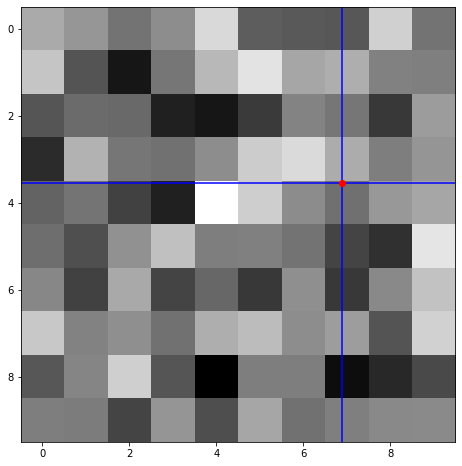

In [9]:
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray', 
          # vmin=alvo.mean()-1000, vmax=alvo.mean()+1000
          )

plt.axhline(yc, color='blue')
plt.axvline(xc, color='blue')
plt.plot(xc, yc, 'ro')

plt.show()

    Nesse caso, uso os valores encontrados no ultimo frame em que o corpo não estava sendo ocultado para ter uma ideia de onde o corpo pode estar. É intuitivo deduzir que o pixel mais brilhante, que está bem proximo deste ponto, é referente ao corpo de fato. Decidi utilizar este ponto como o centro. 

In [10]:
xc = 6.36 
yc = 5.16

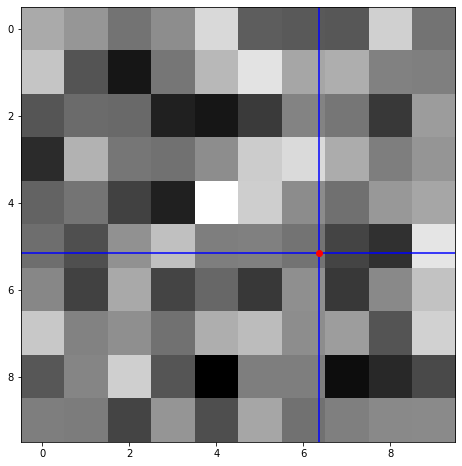

In [11]:
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray', 
          # vmin=alvo.mean()-1000, vmax=alvo.mean()+1000
          )

plt.axhline(yc, color='blue')
plt.axvline(xc, color='blue')
plt.plot(xc, yc, 'ro')

plt.show()

In [12]:
np.where(alvo == alvo.max())

(array([4]), array([4]))

In [13]:
yc = 4
xc = 4

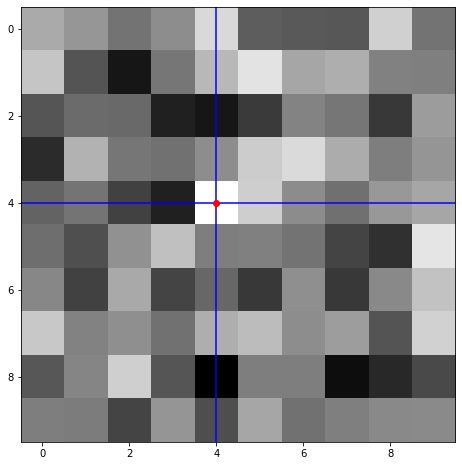

In [14]:
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray', 
          # vmin=alvo.mean()-1000, vmax=alvo.mean()+1000
          )

plt.axhline(yc, color='blue')
plt.axvline(xc, color='blue')
plt.plot(xc, yc, 'ro')

plt.show()

 - Agora determinamos os pixels que iremos somar

In [15]:
y = np.arange(alvo.shape[0])
x = np.arange(alvo.shape[1])

x, y = np.meshgrid(x, y)

- Queremos indentificar a melhor abertura

In [16]:
fluxos = np.array([])
abertura = np.arange(1,8)

for i in abertura:
    mask = np.sqrt((x - xc)**2 + (y - yc)**2) < i
    fluxos = np.append(fluxos, np.sum(alvo[mask]))

Text(0.5, 0, 'Fuxo [contagens]')

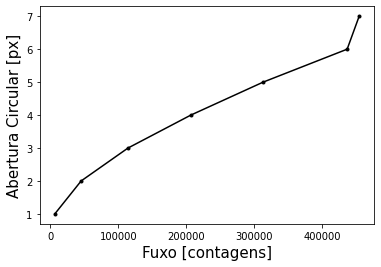

In [17]:
plt.plot(fluxos, abertura, 'k.-')
plt.ylabel('Abertura Circular [px]', fontsize=15)
plt.xlabel('Fuxo [contagens]', fontsize=15)

 - Determinando o fundo de céu...

In [18]:
outer_ring = 5
inner_ring = 3

mask_sky = ((np.sqrt((x - xc)**2 + (y - yc)**2) < outer_ring) 
           *(np.sqrt((x - xc)**2 + (y - yc)**2) > inner_ring))


image_sky = np.copy(alvo.astype('float64')) # Puramente para ilustração
image_sky[~mask_sky] = np.nan  # Puramente para ilustração

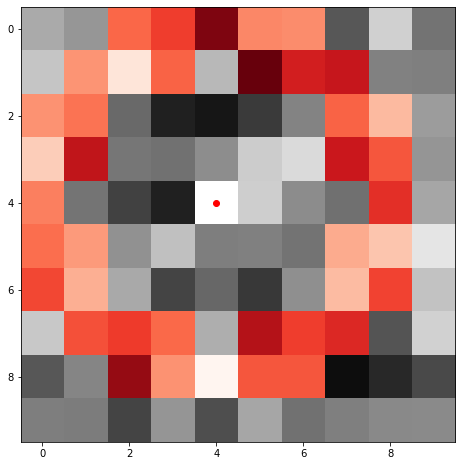

In [19]:
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray')
plt.imshow(image_sky, cmap='Reds', 
           #alpha=1.0
          )
plt.plot(xc, yc, 'ro')
plt.show()

In [20]:
flux_sky = np.sum(alvo[mask_sky])
print('Flux do céu:', flux_sky)

npix_sky = len(alvo[mask_sky])
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu:' + 
      '{:.2f} +/- {:.2f}'.format(alvo[mask_sky].mean(),
                                 alvo[mask_sky].std()))

Flux do céu: 179474
Número de pixeis: 40


Distribuição do Fundo do céu:4486.85 +/- 736.51


 - Agora podemos analisar a melhor abertura possivel

In [21]:
fluxos = np.array([])
npixs = np.array([])

abertura = np.arange(1,8)
for i in abertura:
    mask = np.sqrt((x - xc)**2 + (y - yc)**2) < i
    fluxos = np.append(fluxos, np.sum(alvo[mask]))
    npixs  = np.append(npixs, len(alvo[mask]))

    
fluxos_new = fluxos - npixs*alvo[mask_sky].mean()

snr = fluxos_new/np.sqrt(fluxos_new + 
                         npixs*alvo[mask_sky].mean())

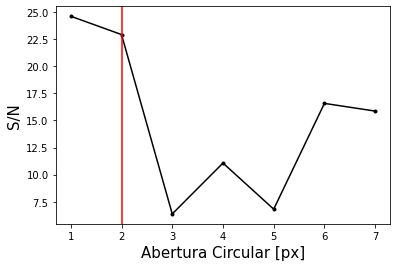

In [22]:
plt.plot(abertura, snr, 'k.-')
plt.xlabel('Abertura Circular [px]', fontsize=15)
plt.ylabel('S/N', fontsize=15)
plt.axvline(2, color='r')
#plt.axhline(587.83, color = 'g')
plt.show()

In [23]:
abertura = 2

mask = np.sqrt((x - xc)**2 + (y - yc)**2) < abertura

image_copy = np.copy(alvo.astype('float64')) # Puramente para ilustração
image_copy[~mask] = np.nan  # Puramente para ilustração

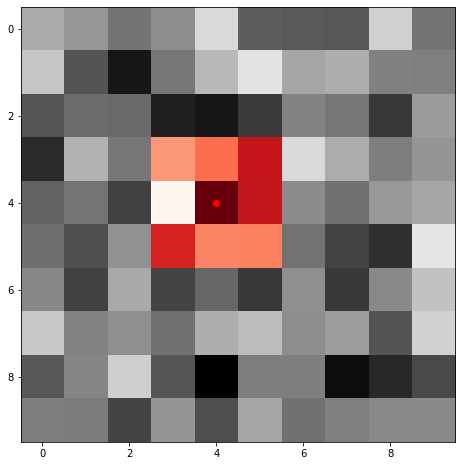

In [24]:
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray', 
          #vmin=im_data.mean()-100, 
          #vmax=im_data.mean()+100
          )

plt.imshow(image_copy, cmap='Reds', 
          #vmin=im_data.mean()-100, 
          #vmax=im_data.mean()+100
        )
plt.plot(xc, yc, 'ro')
plt.show()

In [25]:
fluxo = np.sum(alvo[mask])
print(fluxo)

npix = len(alvo[mask])
print(npix)

45258
9


In [26]:
flux_sky = np.sum(alvo[mask_sky])
print('Flux do céu:', flux_sky)

npix_sky = len(alvo[mask_sky])
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu:' + 
      '{:.2f} +/- {:.2f}'.format(alvo[mask_sky].mean(),
                                 alvo[mask_sky].std()))

Flux do céu: 179474
Número de pixeis: 40


Distribuição do Fundo do céu:4486.85 +/- 736.51


In [27]:
fluxo_correto = fluxo - npix*alvo[mask_sky].mean()

snr = (fluxo_correto/np.sqrt((fluxo_correto + 
       npix*alvo[mask_sky].mean())))

print('S/N:', snr) #Realista!
print('Fluxo do alvo: ', fluxo_correto)

S/N: 22.92171933460507
Fluxo do alvo:  4876.3499999999985


 - Calibrador (Titania):

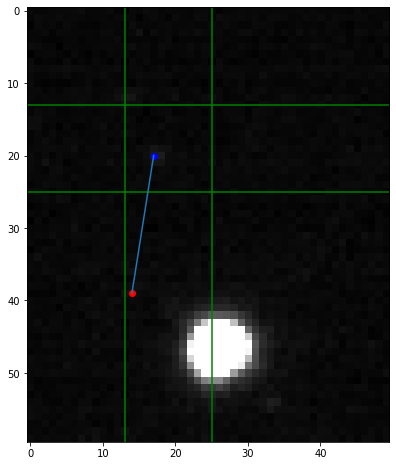

In [28]:
new_data = im_data[140:200,200:250]
plt.figure(figsize=[8, 8])
plt.imshow(new_data, cmap='gray')
#plt.axvline(15, color='r')
#plt.axhline(36, color='r')
plt.axvline(13, color='g')
plt.axvline(25, color='g')
plt.axhline(25, color='g')
plt.axhline(13, color='g')


##Calibrador
plt.plot(17, 20, 'bo') #Antes estava (18,18) -> dx=-1 dy=-+2
## Alvo
plt.plot(14, 39, 'ro') #Aplicando mesmo dx,dy

## Distancia entre eles
#plt.plot([1, 10], [1, 10]) irá traçar uma reta ligando os pontos (1,1) e (10,10)
plt.plot([17,14],[20,39])

plt.show()

In [29]:
def reta_entre_pts(xa,xb,ya,yb):
    return np.sqrt((xb-xa)**2 + (yb - ya)**2)
print('Distancia entre Titania e Estrela alvo + Umbriel: ',reta_entre_pts(17,14,39,20))

Distancia entre Titania e Estrela alvo + Umbriel:  19.235384061671343


    Obviamente bate com a distancia calculada no primeiro frame. Me pareceu um bom chute para a posição do alvo. A partir desse chute, recortei e utilizei o pixel mais brilhante para centralizar melhor. Talvez essa tática tenha causado algum tipo de distorção caso a ocultação esteja na fase parcial. Isso pode levar a uma diferença mais gritante quanto ao resultado do fluxo calculado aqui e pelo PRAIA.

 - Continuando... vamos calcular o fluxo do calibrador deste frame para termos noção do quanto o fluxo caiu durante o evento.

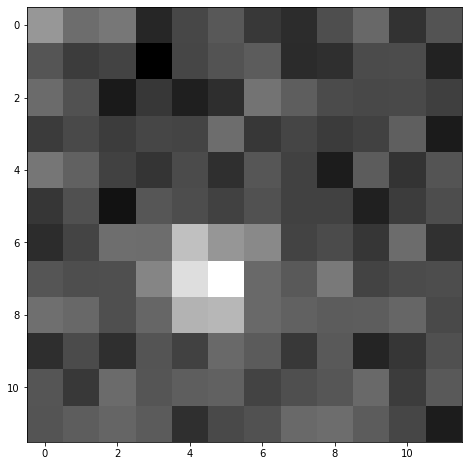

In [30]:
cal = new_data[13:25,13:25] # Imagem do calibrador -> Titania
plt.figure(figsize=[8, 8])
plt.imshow(cal, cmap='gray')
plt.show()

In [31]:
xc, yc = momento(cal)
print(xc, yc)

4.43016731192332 7.135655723031756


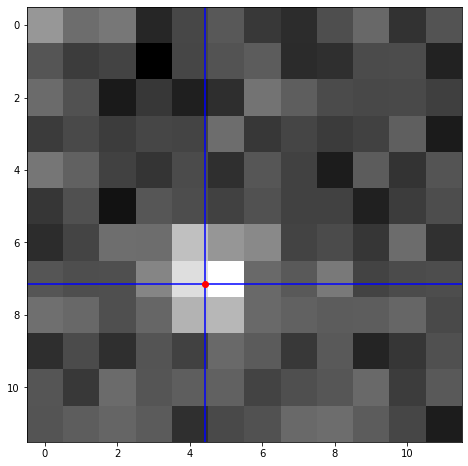

In [32]:
plt.figure(figsize=[8, 8])
plt.imshow(cal, cmap='gray')
plt.axhline(yc, color='blue')
plt.axvline(xc, color='blue')
plt.plot(xc, yc, 'ro')
plt.show()

In [33]:
y = np.arange(cal.shape[0])
x = np.arange(cal.shape[1])

x, y = np.meshgrid(x, y)

outer_ring = 5
inner_ring = 3

mask_sky = ((np.sqrt((x - xc)**2 + (y - yc)**2) < outer_ring) 
           *(np.sqrt((x - xc)**2 + (y - yc)**2) > inner_ring))


image_sky = np.copy(cal.astype('float64')) # Puramente para ilustração
image_sky[~mask_sky] = np.nan  # Puramente para ilustração

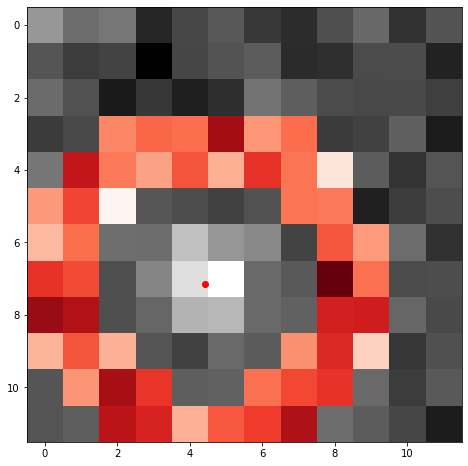

In [34]:
plt.figure(figsize=[8, 8])
plt.imshow(cal, cmap='gray')
plt.imshow(image_sky, cmap='Reds', 
           #alpha=1.0
          )
plt.plot(xc, yc, 'ro')
plt.show()

In [35]:
flux_sky = np.sum(cal[mask_sky])
print('Flux do céu:', flux_sky)

npix_sky = len(cal[mask_sky])
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu:' + 
      '{:.2f} +/- {:.2f}'.format(cal[mask_sky].mean(),
                                 cal[mask_sky].std()))

Flux do céu: 203443
Número de pixeis: 49


Distribuição do Fundo do céu:4151.90 +/- 618.51


In [36]:
abertura = 2 # Sempre usarei essa abertura pois é a melhor, na média, entre os frames.

mask = np.sqrt((x - xc)**2 + (y - yc)**2) < abertura

image_copy = np.copy(cal.astype('float64')) # Puramente para ilustração
image_copy[~mask] = np.nan  # Puramente para ilustração

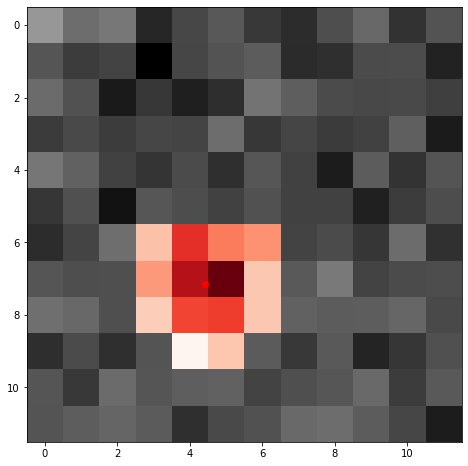

In [37]:
plt.figure(figsize=[8, 8])
plt.imshow(cal, cmap='gray', 
          #vmin=im_data.mean()-100, 
          #vmax=im_data.mean()+100
          )

plt.imshow(image_copy, cmap='Reds', 
          #vmin=im_data.mean()-100, 
          #vmax=im_data.mean()+100
        )
plt.plot(xc, yc, 'ro')
plt.show()

In [38]:
fluxo = np.sum(cal[mask])
print(fluxo)

npix = len(cal[mask])
print(npix)

86625
14


In [39]:
flux_sky = np.sum(cal[mask_sky])
print('Flux do céu:', flux_sky)

npix_sky = len(cal[mask_sky])
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu:' + 
      '{:.2f} +/- {:.2f}'.format(cal[mask_sky].mean(),
                                 cal[mask_sky].std()))

Flux do céu: 203443
Número de pixeis: 49


Distribuição do Fundo do céu:4151.90 +/- 618.51


In [40]:
fluxo_cal = fluxo - npix*cal[mask_sky].mean()

snr = (fluxo_cal/np.sqrt((fluxo_cal + 
       npix*cal[mask_sky].mean())))

print('S/N do Calibrador:', snr) #Realista!
print('Fluxo do Calibrador: ', fluxo_cal)

S/N do Calibrador: 96.8276272120957
Fluxo do Calibrador:  28498.428571428572


In [41]:
flux_ratio = 4876.35/28498.42
flux_ratio

0.17110948606975407